In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision.datasets import ImageFolder

import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from PIL import Image
from collections import defaultdict

In [2]:
CONFIG = {
    'seed': 42,
    'model_name': 'efficientnet_b4',
    'num_classes': 100,
    'batch_size': 64,
    'num_workers': 4,
    'lr': 3e-4,
    'weight_decay': 1e-5,
    'epochs': 10,#30,
    'tta_steps': 5,
    'mixup_alpha': 0.2,
    'cutmix_alpha': 1.0,
    'label_smoothing': 0.1,
    'early_stop_patience': 7
}
path = "/home/jupyter/datasphere/project/"
train_dir = path + "data/train"
test_dir = path + "data/test"

In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed(CONFIG['seed'])

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

## 1) Проанализировать данные, посмотреть на баланс классов, посмотреть на представителей классов, сделать выводы. (0.5 балла).

100%|██████████| 9510/9510 [00:08<00:00, 1187.45it/s]

Минальное кол-во изображений в классе: 32
Максимальное кол-во изображений в классе: 150
max/min: 4.7 раз
Среднее: 95.1
Медиана: 100.0
Стандартное отклонение: 35.3 (37% от среднего)


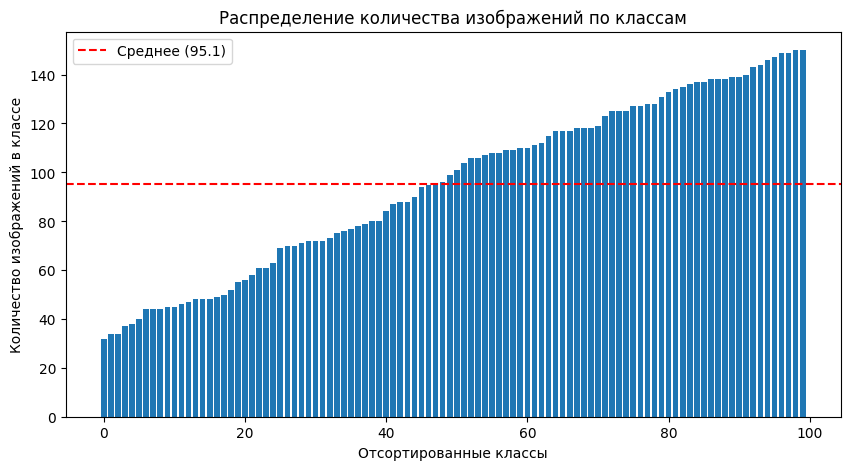

In [5]:
# Получаем классы и количество изображений
class_names = train_loader.dataset.classes
class_counts = [0] * len(class_names)

# Считаем количество изображений для каждого класса
for _, label in tqdm(train_loader.dataset):
  class_counts[label] += 1

# Основные метрики
min_count = min(class_counts)
max_count = max(class_counts)
mean_count = np.mean(class_counts)
median_count = np.median(class_counts)
std_dev = np.std(class_counts)

print(f"Минальное кол-во изображений в классе: {min_count}")
print(f"Максимальное кол-во изображений в классе: {max_count}")
print(f"max/min: {max_count/min_count:.1f} раз")
print(f"Среднее: {mean_count:.1f}")
print(f"Медиана: {median_count}")
print(f"Стандартное отклонение: {std_dev:.1f} ({std_dev/mean_count*100:.0f}% от среднего)")

# Визуализация
plt.figure(figsize=(10, 5))
plt.bar(range(len(class_counts)), sorted(class_counts))
plt.axhline(mean_count, color='r', linestyle='--', label=f'Среднее ({mean_count:.1f})')
plt.xlabel("Отсортированные классы")
plt.ylabel("Количество изображений в классе")
plt.title("Распределение количества изображений по классам")
plt.legend()
plt.show()

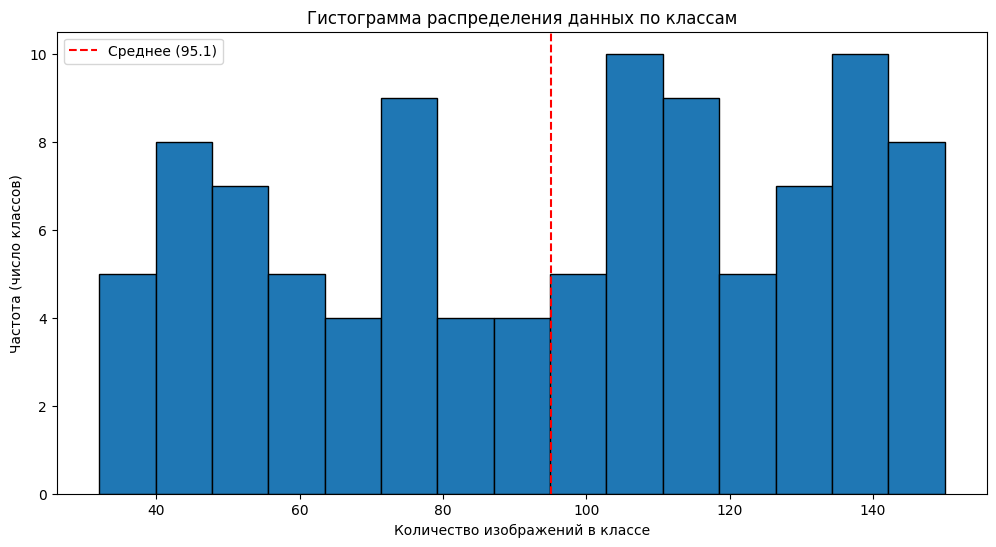

In [6]:
plt.figure(figsize=(12,6))
plt.hist(class_counts, bins=15, edgecolor='black')
plt.axvline(95.1, color='red', linestyle='--', label=f'Среднее (95.1)')
plt.xlabel('Количество изображений в классе')
plt.ylabel('Частота (число классов)')
plt.title('Гистограмма распределения данных по классам')
plt.legend()
plt.show()

In [7]:
# from torchvision.utils import make_grid

# def show_images(train_loader, class_idx, class_names, num_samples=5):
#     # Получаем индексы всех изображений данного класса
#     indices = [i for i, (_, label) in enumerate(train_loader) if label == class_idx]

#     # Выбираем случайные примеры (без повторений, если возможно)
#     selected_indices = np.random.choice(indices, min(num_samples, len(indices)), replace=False)

#     # Загружаем изображения
#     images = [train_loader[i][0] for i in selected_indices]

#     # Создаём сетку изображений
#     grid = make_grid(images, nrow=num_samples, normalize=True, padding=2)

#     # Отображаем
#     plt.figure(figsize=(15, 3))
#     plt.imshow(grid.permute(1, 2, 0))
#     plt.title(f"Класс {class_idx} ({class_names[class_idx]}): {len(indices)} примеров")
#     plt.axis('off')
#     plt.show()

# # Получаем названия классов
# class_names = train_loader.dataset.classes

# # Создаём список уникальных классов, присутствующих в данных
# unique_classes = sorted(set(train_loader.dataset.targets))

# # Для каждого класса показываем примеры
# for class_idx in unique_classes:
#     show_images(train_loader.dataset, class_idx, class_names)

### Выводы:
Датасет имеет значительный дисбаланс классов (от 32 до 150 изображений), что может ухудшить качество модели на малых классах.
Классы распределены неравномерно, но без явного доминирования одного/двух классов.
Однако если изображения в каждом классе разнообразны и нет технических дефектов, проблему можно решить взвешенным лоссом и аугментацией.
Критически важно мониторить метрики (precision/recall) для каждого класса, а не только общую accuracy.

## 2) Проанализировать хороший аугментационный пайплайн с помощью albumentations. Собрать подготовленный пайплайн в погрузчик данных на модель. (1.5 балла).

### Проверим как распределены пиксели в датасете для их нормализации

In [8]:
# Берём 1 батч данных и проверяем диапазон
for images, _ in train_loader:
    print(f"Диапазон значений в батче: [{images.min()}, {images.max()}]")
    break

# Считаем mean/std по 100 изображениям
subset = torch.stack([train_dataset[i][0] for i in range(100)])
mean = subset.mean(dim=[0, 2, 3])  # По каналам (C)
std = subset.std(dim=[0, 2, 3])

print(f"Среднее по каналам (R, G, B): {mean}")
print(f"Стандартное отклонение: {std}")

Диапазон значений в батче: [0.0, 1.0]
Среднее по каналам (R, G, B): tensor([0.4178, 0.3911, 0.3505])
Стандартное отклонение: tensor([0.2524, 0.2361, 0.2344])


### Аугментационный пайплайн

In [9]:
# Минимальные аугментации
base_train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=mean, std=std, max_pixel_value=1.0),
    ToTensorV2()
])
# Максимальные аугментации
pro_train_transform = A.Compose([
    A.RandomResizedCrop(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.CoarseDropout(max_holes=1, max_height=32, max_width=32, p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [10]:
# Проверка формата после преобразований
for images, _ in train_loader:
    print(f"Размер батча: {images.shape}")          # Ожидается [32, 3, 32, 32]
    print(f"Диапазон значений: [{images.min()}, {images.max()}]")  # Должно быть ~[-3, 3]
    break

Размер батча: torch.Size([32, 3, 32, 32])
Диапазон значений: [0.0, 1.0]


### Обертка над датасетом для работы с аугментацией

In [11]:
class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = datasets.ImageFolder(root, transform=None)
        self.transform = transform
        self.targets = self.dataset.targets
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if self.transform:
            img = self.transform(image=np.array(img))['image']
        return img, label

class TestDataset(Dataset):
    def __init__(self, root, transform=None):
        self.image_paths = sorted([os.path.join(root, f) for f in os.listdir(root) 
                                if f.endswith(('.png', '.jpg', '.jpeg'))])
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image=np.array(image))['image']
        return image, os.path.basename(self.image_paths[idx])


## 3) Поделить данные на трейн-валидацию, обучить базовую модель (с и без transfer learning) без навороченных аугментаций (только отражение по горизонтали и вертикали) и с навороченными. Попробуйте применить продвинутые методы апскейлинга для подачи модели нужного размера для transfer learning. Проверить результаты моделей с аугментацией на тесте и без. Сделать аугментацию моделей на валидации (или тесте на каггле). Снабдить обучение моделей графиками отрисовки лосей и метрик, шедулерами, свитч лосей (метрик), сохранение лучшей модели, ранней остановкой, вормапом. (4.5 балла)

### Поделить данные на трейн-валидацию

In [12]:
dataset = CustomDataset(train_dir)
train_idx, valid_idx = train_test_split(
    np.arange(len(dataset)),
    test_size=0.2,
    stratify=dataset.targets,
    random_state=CONFIG['seed']
)

In [13]:
# Базовая CNN модель
class BasicCNN(nn.Module):
    def __init__(self, num_classes=100):  # Предполагаем 100 классов
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 128),  # Для 32x32 изображений после двух MaxPool
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [14]:
# Навороченная модель
class ProModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.IMAGENET1K_V1)
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier[1] = nn.Linear(in_features, CONFIG['num_classes'])
        
    def forward(self, x):
        return self.backbone(x)

In [15]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, scheduler, device):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.best_acc = 0.0
        self.history = defaultdict(list)
        
    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_targets = []
        
        for inputs, targets in tqdm(self.train_loader, desc='Training'):
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            original_targets = targets.clone()
            
            # Mixup/Cutmix
            if np.random.rand() < 0.5:
                lam = np.random.beta(CONFIG['mixup_alpha'], CONFIG['mixup_alpha'])
                rand_index = torch.randperm(inputs.size()[0]).to(self.device)
                inputs = lam * inputs + (1 - lam) * inputs[rand_index]
                targets = (targets, targets[rand_index], lam)
            else:
                lam = np.random.beta(CONFIG['cutmix_alpha'], CONFIG['cutmix_alpha'])
                rand_index = torch.randperm(inputs.size()[0]).to(self.device)
                bbx1, bby1, bbx2, bby2 = self.rand_bbox(inputs.size(), lam)
                inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
                lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))
                targets = (targets, targets[rand_index], lam)
            
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            
            if isinstance(targets, tuple):
                loss = self.criterion(outputs, targets[0]) * targets[2] + \
                       self.criterion(outputs, targets[1]) * (1. - targets[2])
            else:
                loss = self.criterion(outputs, targets)
                
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(original_targets.cpu().numpy())
            total += targets[0].size(0) if isinstance(targets, tuple) else targets.size(0)
            correct += predicted.eq(targets[0] if isinstance(targets, tuple) else targets).sum().item()
            
        train_precision = precision_score(all_targets, all_preds, average='weighted', zero_division=0)
        train_recall = recall_score(all_targets, all_preds, average='weighted', zero_division=0)
        train_loss = running_loss / len(self.train_loader)
        train_acc = correct / total
        return train_loss, train_acc, train_precision, train_recall
    
    @staticmethod
    def rand_bbox(size, lam):
        W = size[2]
        H = size[3]
        cut_rat = np.sqrt(1. - lam)
        cut_w = int(W * cut_rat)
        cut_h = int(H * cut_rat)

        cx = np.random.randint(W)
        cy = np.random.randint(H)

        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)

        return bbx1, bby1, bbx2, bby2
    
    def val_epoch(self):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for inputs, targets in tqdm(self.val_loader, desc='Validation'):
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                val_preds.extend(predicted.cpu().numpy())
                val_targets.extend(targets.cpu().numpy())
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                
        valid_loss = running_loss / len(self.val_loader)
        valid_acc = correct / total
        val_precision = precision_score(val_targets, val_preds, average='weighted', zero_division=0)
        val_recall = recall_score(val_targets, val_preds, average='weighted', zero_division=0)
        return valid_loss, valid_acc, val_precision, val_recall
    
    def fit(self):
        early_stop_counter = 0
        
        for epoch in range(CONFIG['epochs']):
            print(f"\nEpoch {epoch+1}/{CONFIG['epochs']}")
            train_loss, train_acc, train_precision, train_recall = self.train_epoch()
            valid_loss, valid_acc, valid_precision, valid_recall = self.val_epoch()
            
            self.scheduler.step(valid_loss)
            
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['valid_loss'].append(valid_loss)
            self.history['valid_acc'].append(valid_acc)
            
            self.history['train_precision'].append(train_precision)
            self.history['valid_precision'].append(valid_precision)
            self.history['train_recall'].append(train_recall)
            self.history['valid_recall'].append(valid_recall)
            
            print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
            print(f"Valid Loss: {valid_loss:.4f} | Acc: {valid_acc:.4f}")
            
            # Save best model
            if valid_acc > self.best_acc:
                self.best_acc = valid_acc
                torch.save(self.model.state_dict(), 'best_model.pth')
                early_stop_counter = 0
            else:
                early_stop_counter += 1
                
            if early_stop_counter >= CONFIG['early_stop_patience']:
                print("Early stopping triggered")
                break

In [16]:
def plot_training(train_losses, val_losses, train_accs, val_accs, 
                  train_precision, valid_precision, train_recall, valid_recall):
    epochs = range(len(train_losses))

    plt.figure(figsize=(12,6))

    plt.subplot(2,2,1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.title('Losses')
    plt.legend()
    plt.grid(True)

    plt.subplot(2,2,2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Val Accuracy')
    plt.title('Accuracies')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2,2,3)
    plt.plot(epochs, train_precision, label='Train Precision')
    plt.plot(epochs, valid_precision, label='Val Precision')
    plt.title('Precision')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2,2,4)
    plt.plot(epochs, train_recall, label='Train Recall')
    plt.plot(epochs, valid_recall, label='Val Recall')
    plt.title('Recall')
    plt.legend()
    plt.grid(True)
    
    plt.show()

### Обучить базовую модель (с и без transfer learning) без навороченных аугментаций (только отражение по горизонтали и вертикали) и с навороченными. Попробуйте применить продвинутые методы апскейлинга для подачи модели нужного размера для transfer learning.

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss(label_smoothing=CONFIG['label_smoothing'])

#### Базовая модеь без transfer learning без навороченных аугментаций (+ метрики)

In [18]:
train_dataset = Subset(dataset, train_idx)
train_dataset.dataset.transform = base_train_transform

val_dataset = Subset(dataset, valid_idx)
val_dataset.dataset.transform = val_transform

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

In [19]:
base_model = BasicCNN(num_classes=len(train_dataset.dataset.dataset.classes))
base_optimizer = optim.AdamW(base_model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
base_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    base_optimizer, 
    mode='max', 
    factor=0.5, 
    patience=3, 
    verbose=True
)

In [20]:
base_model_simp_aug_trainer = Trainer(
    model=base_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=base_optimizer,
    scheduler=base_scheduler,
    device=device
)
base_model_simp_aug_trainer.fit()


Epoch 1/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 20.99it/s]


Train Loss: 4.5073 | Acc: 0.0344
Valid Loss: 4.2690 | Acc: 0.0768

Epoch 2/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 20.65it/s]


Train Loss: 4.2494 | Acc: 0.0727
Valid Loss: 4.0646 | Acc: 0.1199

Epoch 3/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 20.23it/s]


Train Loss: 4.0399 | Acc: 0.1091
Valid Loss: 3.8906 | Acc: 0.1441

Epoch 4/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 20.58it/s]

Train Loss: 3.8278 | Acc: 0.1201
Valid Loss: 3.8037 | Acc: 0.1777



Epoch 5/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 20.54it/s]


Epoch 00005: reducing learning rate of group 0 to 1.5000e-04.
Train Loss: 3.5805 | Acc: 0.1970
Valid Loss: 3.8199 | Acc: 0.1840

Epoch 6/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 20.75it/s]


Train Loss: 3.2665 | Acc: 0.2487
Valid Loss: 3.7779 | Acc: 0.1814

Epoch 7/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 20.82it/s]


Train Loss: 3.2196 | Acc: 0.2550
Valid Loss: 3.7741 | Acc: 0.1782

Epoch 8/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 20.79it/s]


Train Loss: 2.9905 | Acc: 0.3344
Valid Loss: 3.8344 | Acc: 0.1940

Epoch 9/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 20.94it/s]


Epoch 00009: reducing learning rate of group 0 to 7.5000e-05.
Train Loss: 2.8377 | Acc: 0.3030
Valid Loss: 3.8782 | Acc: 0.1872

Epoch 10/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 21.23it/s]


Train Loss: 2.5771 | Acc: 0.3754
Valid Loss: 3.8570 | Acc: 0.2024


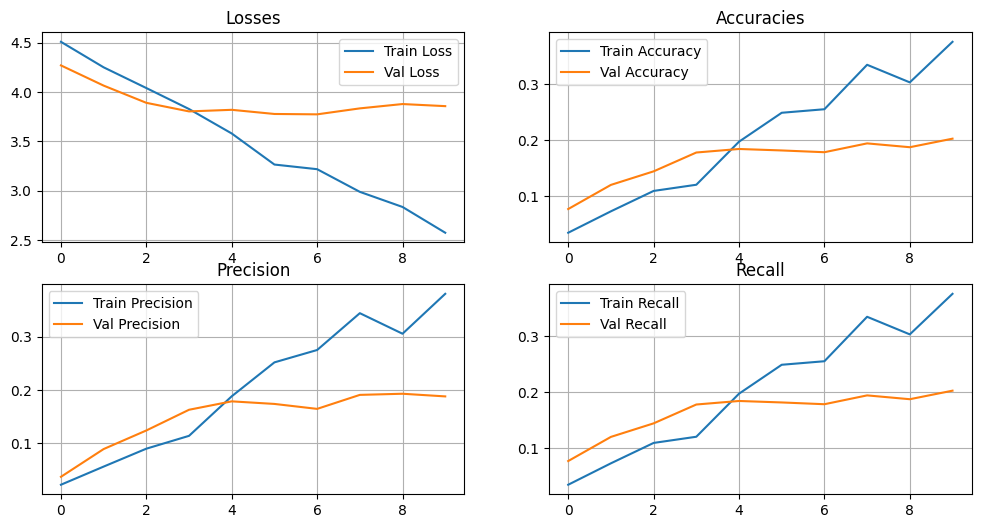

In [21]:
history = base_model_simp_aug_trainer.history
plot_training(history['train_loss'], history['valid_loss'], history['train_acc'], history['valid_acc'],
             history['train_precision'], history['valid_precision'], history['train_recall'], history['valid_recall'])

#### Базовая модеь с transfer learning без навороченных аугментаций (+ метрики)

In [22]:
pro_model = ProModel()
pro_optimizer = optim.AdamW(pro_model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
base_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    pro_optimizer, 
    mode='max', 
    factor=0.5, 
    patience=3, 
    verbose=True
)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /tmp/xdg_cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 103MB/s] 


In [23]:
pro_model_simp_aug_trainer = Trainer(
    model=base_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=base_optimizer,
    scheduler=base_scheduler,
    device=device
)
pro_model_simp_aug_trainer.fit()


Epoch 1/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 16.70it/s]


Train Loss: 2.5594 | Acc: 0.4176
Valid Loss: 3.8836 | Acc: 0.1993

Epoch 2/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 19.89it/s]


Train Loss: 2.5617 | Acc: 0.4110
Valid Loss: 3.9001 | Acc: 0.1919

Epoch 3/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 20.29it/s]


Train Loss: 2.5579 | Acc: 0.4335
Valid Loss: 3.9196 | Acc: 0.2008

Epoch 4/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 19.69it/s]


Train Loss: 2.5193 | Acc: 0.4836
Valid Loss: 3.9204 | Acc: 0.1977

Epoch 5/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 20.05it/s]


Train Loss: 2.4979 | Acc: 0.5062
Valid Loss: 3.9334 | Acc: 0.1924

Epoch 6/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 20.40it/s]


Train Loss: 2.3300 | Acc: 0.4870
Valid Loss: 3.9544 | Acc: 0.1877

Epoch 7/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 19.47it/s]


Train Loss: 2.4177 | Acc: 0.4490
Valid Loss: 3.9545 | Acc: 0.1930

Epoch 8/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 19.23it/s]


Train Loss: 2.2666 | Acc: 0.4669
Valid Loss: 3.9829 | Acc: 0.1930

Epoch 9/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 19.29it/s]


Train Loss: 2.3351 | Acc: 0.4481
Valid Loss: 3.9979 | Acc: 0.1835

Epoch 10/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 19.71it/s]

Train Loss: 2.2275 | Acc: 0.5290
Valid Loss: 4.0090 | Acc: 0.1909
Early stopping triggered


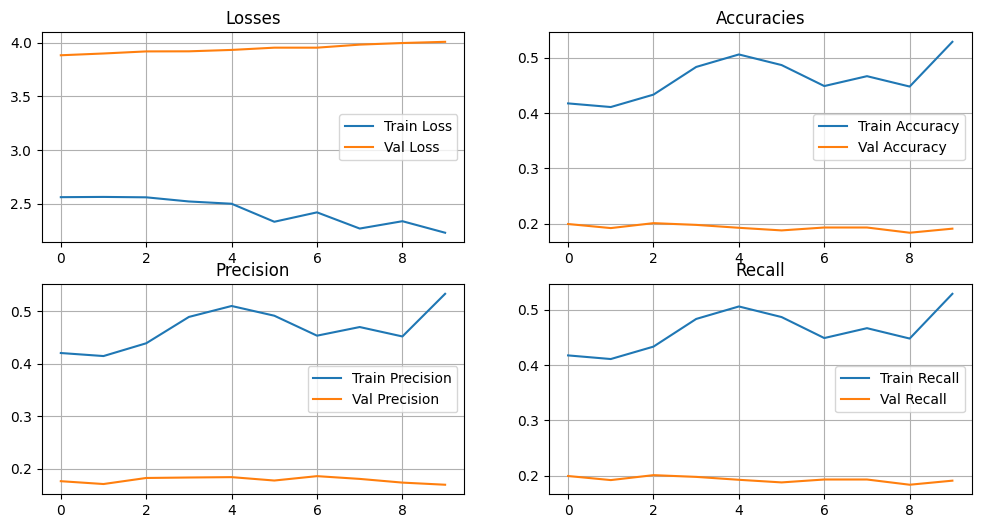

In [24]:
history = pro_model_simp_aug_trainer.history
plot_training(history['train_loss'], history['valid_loss'], history['train_acc'], history['valid_acc'],
             history['train_precision'], history['valid_precision'], history['train_recall'], history['valid_recall'])

#### Базовая модеь без transfer learning с навороченной аугментацией (+ метрики)

In [25]:
train_dataset = Subset(dataset, train_idx)
train_dataset.dataset.transform = pro_train_transform

val_dataset = Subset(dataset, valid_idx)
val_dataset.dataset.transform = val_transform

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

In [26]:
base_model = BasicCNN(num_classes=len(train_dataset.dataset.dataset.classes))
base_optimizer = optim.AdamW(base_model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
base_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    base_optimizer, 
    mode='max', 
    factor=0.5, 
    patience=3, 
    verbose=True
)

In [27]:
base_model_pro_aug_trainer = Trainer(
    model=base_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=base_optimizer,
    scheduler=base_scheduler,
    device=device
)
base_model_pro_aug_trainer.fit()


Epoch 1/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 19.64it/s]


Train Loss: 4.5901 | Acc: 0.0231
Valid Loss: 4.4189 | Acc: 0.0463

Epoch 2/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 19.06it/s]


Train Loss: 4.3971 | Acc: 0.0473
Valid Loss: 4.2302 | Acc: 0.0920

Epoch 3/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 19.66it/s]


Train Loss: 4.2499 | Acc: 0.0687
Valid Loss: 4.0860 | Acc: 0.1162

Epoch 4/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 19.08it/s]


Train Loss: 4.0864 | Acc: 0.0845
Valid Loss: 3.9756 | Acc: 0.1309

Epoch 5/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 19.77it/s]


Epoch 00005: reducing learning rate of group 0 to 1.5000e-04.
Train Loss: 4.0132 | Acc: 0.1125
Valid Loss: 3.8765 | Acc: 0.1540

Epoch 6/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 19.67it/s]


Train Loss: 3.8364 | Acc: 0.1325
Valid Loss: 3.8183 | Acc: 0.1693

Epoch 7/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 19.61it/s]


Train Loss: 3.7781 | Acc: 0.1610
Valid Loss: 3.7909 | Acc: 0.1735

Epoch 8/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 20.04it/s]


Train Loss: 3.6631 | Acc: 0.1834
Valid Loss: 3.7756 | Acc: 0.1767

Epoch 9/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 20.72it/s]


Epoch 00009: reducing learning rate of group 0 to 7.5000e-05.
Train Loss: 3.5420 | Acc: 0.1920
Valid Loss: 3.7745 | Acc: 0.1682

Epoch 10/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 21.02it/s]

Train Loss: 3.4234 | Acc: 0.2215
Valid Loss: 3.7608 | Acc: 0.1714


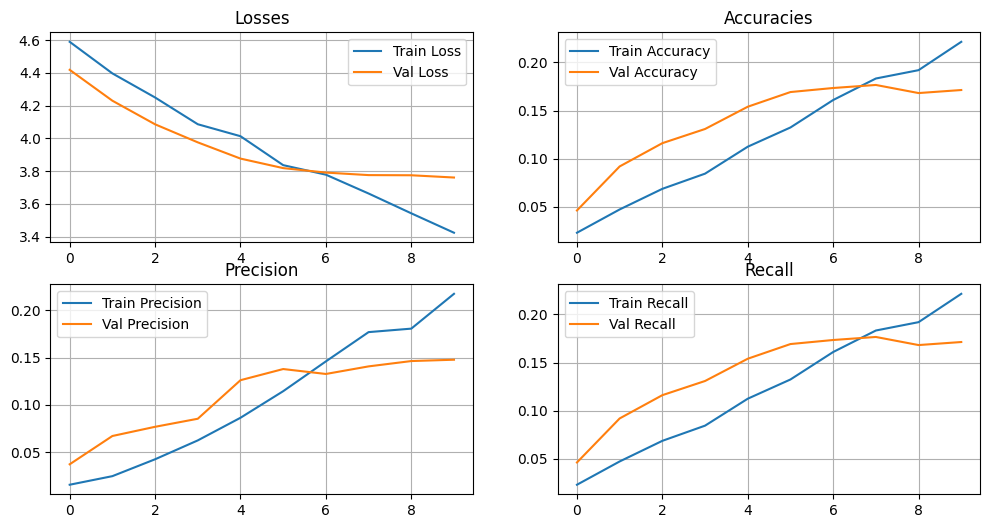

In [28]:
history = base_model_pro_aug_trainer.history
plot_training(history['train_loss'], history['valid_loss'], history['train_acc'], history['valid_acc'],
             history['train_precision'], history['valid_precision'], history['train_recall'], history['valid_recall'])

#### Базовая модеь с transfer learning с навороченной аугментацией (+ метрики)

In [29]:
pro_model = ProModel()
pro_optimizer = optim.AdamW(pro_model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
base_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    pro_optimizer, 
    mode='max', 
    factor=0.5, 
    patience=3, 
    verbose=True
)

In [30]:
pro_model_pro_aug_trainer = Trainer(
    model=base_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=base_optimizer,
    scheduler=base_scheduler,
    device=device
)
pro_model_pro_aug_trainer.fit()


Epoch 1/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 20.11it/s]


Train Loss: 3.4511 | Acc: 0.2141
Valid Loss: 3.7743 | Acc: 0.1809

Epoch 2/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 20.18it/s]


Train Loss: 3.3298 | Acc: 0.2253
Valid Loss: 3.7832 | Acc: 0.1819

Epoch 3/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 19.42it/s]


Train Loss: 3.3213 | Acc: 0.2296
Valid Loss: 3.7747 | Acc: 0.1872

Epoch 4/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 18.89it/s]


Train Loss: 3.2452 | Acc: 0.2956
Valid Loss: 3.8004 | Acc: 0.1751

Epoch 5/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 19.83it/s]


Train Loss: 3.0691 | Acc: 0.2971
Valid Loss: 3.8283 | Acc: 0.1835

Epoch 6/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 20.31it/s]


Train Loss: 3.1452 | Acc: 0.3070
Valid Loss: 3.8211 | Acc: 0.1751

Epoch 7/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 20.31it/s]


Train Loss: 3.0679 | Acc: 0.3043
Valid Loss: 3.8344 | Acc: 0.1819

Epoch 8/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 19.66it/s]


Train Loss: 3.0694 | Acc: 0.3281
Valid Loss: 3.8466 | Acc: 0.1777

Epoch 9/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 20.45it/s]


Train Loss: 3.0445 | Acc: 0.3254
Valid Loss: 3.8517 | Acc: 0.1725

Epoch 10/10


Validation: 100%|██████████| 30/30 [00:01<00:00, 20.66it/s]

Train Loss: 2.8829 | Acc: 0.3613
Valid Loss: 3.8729 | Acc: 0.1788
Early stopping triggered


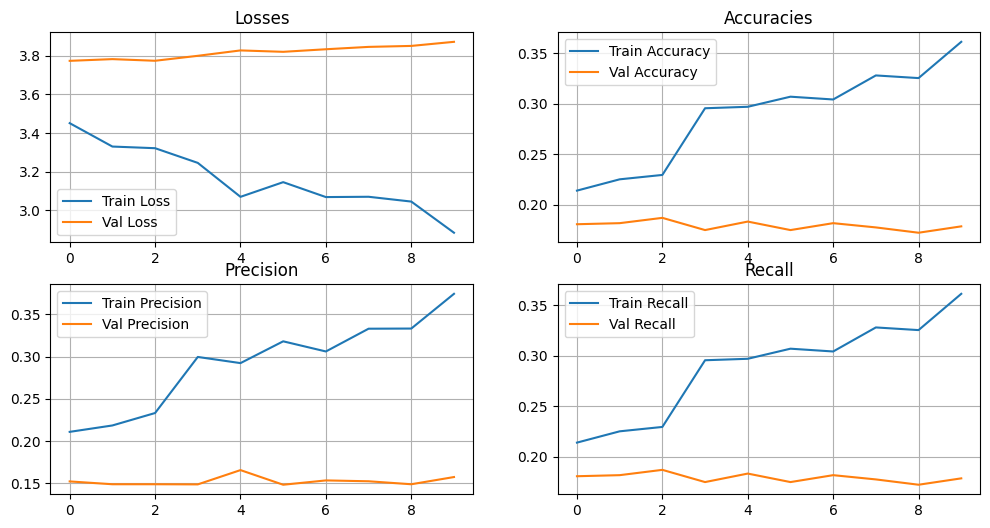

In [31]:
history = pro_model_pro_aug_trainer.history
plot_training(history['train_loss'], history['valid_loss'], history['train_acc'], history['valid_acc'],
             history['train_precision'], history['valid_precision'], history['train_recall'], history['valid_recall'])

## 4) Обучить простенький генератор для дополнительной аугментации данных, настроить для него условную генерацию на классах и аугментационный пайплайн. Изучить влияние сгенерированных данных на перформанс модели. (2 балла)

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConditionalVAE(nn.Module):
    def __init__(self, num_classes, img_size=32, latent_dim=128):
        super().__init__()
        self.num_classes = num_classes
        self.latent_dim = latent_dim
        self.img_size = img_size
        
        # Энкодер
        self.encoder = nn.Sequential(
            nn.Conv2d(3 + num_classes, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Flatten()
        )
        
        # Автоматический расчет размера выхода энкодера
        with torch.no_grad():
            sample = torch.randn(1, 3 + num_classes, img_size, img_size)
            self.encoder_output_dim = self.encoder(sample).shape[1]
        
        # Латентные параметры
        self.fc_mu = nn.Linear(self.encoder_output_dim, latent_dim)
        self.fc_var = nn.Linear(self.encoder_output_dim, latent_dim)
        
        # Декодер
        self.decoder_input = nn.Linear(latent_dim + num_classes, 128 * 4 * 4)
        
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 4, 4)),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x, y):
        # One-hot кодирование и расширение
        y_encoded = F.one_hot(y, self.num_classes).float()
        y_encoded = y_encoded.view(-1, self.num_classes, 1, 1)
        y_encoded = y_encoded.expand(-1, -1, x.shape[2], x.shape[3])
        
        x = torch.cat([x, y_encoded], dim=1)
        x = self.encoder(x)
        return self.fc_mu(x), self.fc_var(x)
    
    def decode(self, z, y):
        # Объединение с меткой класса
        y_encoded = F.one_hot(y, self.num_classes).float()
        z = torch.cat([z, y_encoded], dim=1)
        z = self.decoder_input(z)
        return self.decoder(z)
    
    def forward(self, x, y):
        mu, log_var = self.encode(x, y)
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return self.decode(z, y), mu, log_var

In [33]:
def train_cvae(model, dataloader, num_epochs=50):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    for epoch in range(num_epochs):
        for images, labels in tqdm(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            recon_images, mu, log_var = model(images, labels)
            
            # Расчет потерь
            recon_loss = F.mse_loss(recon_images, images, reduction='sum')
            kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = recon_loss + kl_loss
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        print(f'Epoch {epoch+1}, Loss: {loss.item()/len(dataloader.dataset):.4f}')

In [34]:
def generate_samples(model, num_samples_per_class=100):
    model.eval()
    generated_data = []
    
    for class_idx in range(model.num_classes):
        # Генерация скрытых векторов
        z = torch.randn(num_samples_per_class, model.latent_dim).to(device)
        labels = torch.full((num_samples_per_class,), class_idx).to(device)
        
        with torch.no_grad():
            generated = model.decode(z, labels).cpu()
        
        # Добавление в датасет
        for img in generated:
            generated_data.append((img, class_idx))
    
    return generated_data

In [35]:
cvae = ConditionalVAE(100, 32).to(device)
train_cvae(cvae, train_loader)

generated_data = generate_samples(cvae, num_samples_per_class=50)

class AugmentedDataset(Dataset):
    def __init__(self, original_dataset, generated_data):
        self.original = original_dataset
        self.generated = generated_data
        
    def __len__(self):
        return len(self.original) + len(self.generated)
    
    def __getitem__(self, idx):
        if idx < len(self.original):
            return self.original[idx]
        else:
            return self.generated[idx - len(self.original)]

augmented_train_set = AugmentedDataset(train_dataset, generated_data)
augmented_loader = DataLoader(augmented_train_set, batch_size=128, shuffle=True)

  0%|          | 0/119 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x100352 and 2048x128)

## Сохранение результатов теста

In [ ]:
test_dataset = TestDataset(test_dir, transform=test_transform)
test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers']
)

model = pro_model_pro_aug_trainer.model
model.eval()

all_preds = []
all_files = []

with torch.no_grad():
    for images, filenames in tqdm(test_loader, desc='Testing'):
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_files.extend(filenames)

submission = pd.DataFrame({
    'id': [f.split('.')[0] for f in all_files],  # Без расширения .png
    'target': [train_dataset.dataset.dataset.classes[p] for p in all_preds]  # Или другой требуемый столбец
})

submission.to_csv('submission.csv', index=False)
print("Success")